In [1]:
# Imports and Initial Setup
import numpy as np # For numerical operations and array handling
import librosa # For audio processing and feature extraction
import librosa.display # For displaying audio visualizations
import sounddevice as sd # For recording audio from microphone
import matplotlib.pyplot as plt # For creating plots and visualizations
from datetime import datetime 
import os # For file and directory operations
import pandas as pd # For creating data reports
from tqdm import tqdm # For progress bars
%matplotlib inline

# VoiceBatchProcessor Class Initialization
class VoiceBatchProcessor:
    def __init__(self, 
                 num_recordings=10, # Default number of recordings
                 duration=3, # Default duration in seconds
                 fs=44100, # Sample rate (44.1kHz)
                 output_dir='voice_recordings'):
        """
        Initialize batch processor for multiple voice recordings.
        
        Args:
            num_recordings: Number of recordings to capture
            duration: Duration of each recording in seconds
            fs: Sample rate
            output_dir: Directory to save recordings and results
        """
        self.num_recordings = num_recordings
        self.duration = duration
        self.fs = fs
        self.output_dir = output_dir
        self.recordings = [] # Store raw recordings
        self.features = [] # Store processed features
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

    # Audio Capture Function
    def capture_batch(self, pause_duration=2):
        """Record multiple audio samples with pauses between them."""
        print(f"Starting batch recording session for {self.num_recordings} samples")
        
        for i in range(self.num_recordings):
            print(f"\nRecording {i+1}/{self.num_recordings}")
            print(f"Starting in {pause_duration} seconds...")
            
             # Wait before starting new recording
            sd.sleep(int(pause_duration * 1000))
            
            # Record audio
            print("Recording...")
            audio = sd.rec(int(self.duration * self.fs), 
                         samplerate=self.fs, 
                         channels=1) # Mono channel recording
            sd.wait() # Wait until recording is complete
            print("Recording finished")
            
            # Store recording metadata and audio
            self.recordings.append({
                'id': i+1,
                'timestamp': datetime.now(),
                'audio': audio.flatten(), # Convert to 1D array
                'raw_duration': len(audio) / self.fs
            })
            
            # Save raw audio to file
            filename = os.path.join(self.output_dir, f'recording_{i+1}_raw.npy')
            np.save(filename, audio.flatten())

    # Audio Preprocessing Function
    def preprocess_audio(self, audio):
        """Preprocess a single audio sample."""
        # Normalization - Scale audio to range [-1, 1]
        audio = audio / np.max(np.abs(audio))
        
        # Remove silence from start/end
        trimmed_audio, _ = librosa.effects.trim(audio, top_db=20)
        
        # Pre-emphasis - Boost high frequencies
        processed_audio = librosa.effects.preemphasis(trimmed_audio)
        
        return processed_audio

    # Feature Extraction Function
    def extract_features(self, audio):
        """Extract features from a single audio sample."""

        # Extract MFCCs (Mel-frequency cepstral coefficients)
        # MFCCs represent the short-term power spectrum of sound
            # The Mel scale is designed to mimic how the human ear perceives sound
            # Humans don't perceive frequencies linearly.
        mfccs = librosa.feature.mfcc(y=audio, sr=self.fs, n_mfcc=13)
        
        # Extract Mel spectrogram
        # Visual representation of sound frequencies over time
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.fs)
        
        return mfccs, mel_spec

    # Batch Processing Function
    def process_batch(self):
        """Process all recordings in the batch."""
        print("\nProcessing batch...")
        
        for i, rec in enumerate(tqdm(self.recordings)): # Progress bar
            # Preprocess audio
            processed_audio = self.preprocess_audio(rec['audio'])
            
            # Extract features
            mfccs, mel_spec = self.extract_features(processed_audio)
            
            # Store processed results
            self.features.append({
                'id': rec['id'],
                'processed_audio': processed_audio,
                'mfccs': mfccs,
                'mel_spec': mel_spec,
                'processed_duration': len(processed_audio) / self.fs
            })
            
            # Save processed audio and features
            base_path = os.path.join(self.output_dir, f'recording_{rec["id"]}')
            np.save(f'{base_path}_processed.npy', processed_audio)
            np.save(f'{base_path}_mfccs.npy', mfccs)
            np.save(f'{base_path}_melspec.npy', mel_spec)

    # Modified Visualization Function
def visualize_batch(self, plot_all=True):
    """
    Visualize results for all recordings in the batch.
    Args:
        plot_all: If True, plots all recordings. If False, plots only first 5
    """
    # Use all samples if plot_all=True, otherwise use 5
    display_count = len(self.features) if plot_all else min(len(self.features), 5)
    
    # Create a figure for waveforms
    plt.figure(figsize=(15, 2*display_count))
    plt.suptitle('All Processed Waveforms', fontsize=16)
    for i in range(display_count):
        plt.subplot(display_count, 1, i+1)
        plt.plot(self.features[i]['processed_audio'])
        plt.title(f'Recording {self.features[i]["id"]} Waveform')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Create a figure for mel spectrograms
    plt.figure(figsize=(15, 2*display_count))
    plt.suptitle('All Mel Spectrograms', fontsize=16)
    for i in range(display_count):
        plt.subplot(display_count, 1, i+1)
        img = librosa.display.specshow(
            librosa.power_to_db(self.features[i]['mel_spec'], ref=np.max),
            y_axis='mel', 
            x_axis='time'
        )
        plt.colorbar(img, format='%+2.0f dB')
        plt.title(f'Recording {self.features[i]["id"]} Mel Spectrogram')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Create a figure for MFCCs
    plt.figure(figsize=(15, 2*display_count))
    plt.suptitle('All MFCCs', fontsize=16)
    for i in range(display_count):
        plt.subplot(display_count, 1, i+1)
        img = librosa.display.specshow(
            self.features[i]['mfccs'], 
            x_axis='time'
        )
        plt.colorbar(img)
        plt.title(f'Recording {self.features[i]["id"]} MFCCs')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Report Generation Function
    def generate_report(self):
        """Generate summary report of the batch processing."""

        # Collect metadata for each recording
        report_data = []
        
        for rec, feat in zip(self.recordings, self.features):
            report_data.append({
                'Recording ID': rec['id'],
                'Timestamp': rec['timestamp'],
                'Raw Duration': rec['raw_duration'],
                'Processed Duration': feat['processed_duration'],
                'MFCC Shape': feat['mfccs'].shape,
                'Mel Spec Shape': feat['mel_spec'].shape
            })

        # Create and save report
        report_df = pd.DataFrame(report_data)
        report_df.to_csv(os.path.join(self.output_dir, 'batch_report.csv'), index=False)
        
        return report_df


# Usage example
def run_batch_processing():
    # Initialize processor
    processor = VoiceBatchProcessor(
        num_recordings=10,  
        duration=3,         
        fs=44100,          
        output_dir='voice_batch_results'
    )
    
    # Execute complete pipeline
    processor.capture_batch(pause_duration=2)
    processor.process_batch()
    
    # Visualize all results - Changed max_display to plot_all
    processor.visualize_batch(plot_all=True)  # This was the issue
    
    # Generate report
    report = processor.generate_report()
    print("\nBatch Processing Report:")
    print(report)
    
    return processor

In [2]:
import numpy as np
import librosa
import librosa.display
import sounddevice as sd
import matplotlib.pyplot as plt
from datetime import datetime
import os
import pandas as pd
from tqdm import tqdm
%matplotlib inline

class VoiceBatchProcessor:
    def __init__(self, num_recordings=10, duration=3, fs=44100, output_dir='voice_recordings'):
        self.num_recordings = num_recordings
        self.duration = duration
        self.fs = fs
        self.output_dir = output_dir
        self.recordings = []
        self.features = []
        os.makedirs(output_dir, exist_ok=True)
        
    def capture_batch(self, pause_duration=2):
        print(f"Starting batch recording session for {self.num_recordings} samples")
        
        for i in range(self.num_recordings):
            print(f"\nRecording {i+1}/{self.num_recordings}")
            print(f"Starting in {pause_duration} seconds...")
            sd.sleep(int(pause_duration * 1000))
            
            print("Recording...")
            audio = sd.rec(int(self.duration * self.fs), samplerate=self.fs, channels=1)
            sd.wait()
            print("Recording finished")
            
            self.recordings.append({
                'id': i+1,
                'timestamp': datetime.now(),
                'audio': audio.flatten(),
                'raw_duration': len(audio) / self.fs
            })
            
            filename = os.path.join(self.output_dir, f'recording_{i+1}_raw.npy')
            np.save(filename, audio.flatten())
    
    def preprocess_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        trimmed_audio, _ = librosa.effects.trim(audio, top_db=20)
        processed_audio = librosa.effects.preemphasis(trimmed_audio)
        return processed_audio
    
    def extract_features(self, audio):
        mfccs = librosa.feature.mfcc(y=audio, sr=self.fs, n_mfcc=13)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.fs)
        return mfccs, mel_spec
    
    def process_batch(self):
        print("\nProcessing batch...")
        for i, rec in enumerate(tqdm(self.recordings)):
            processed_audio = self.preprocess_audio(rec['audio'])
            mfccs, mel_spec = self.extract_features(processed_audio)
            
            self.features.append({
                'id': rec['id'],
                'processed_audio': processed_audio,
                'mfccs': mfccs,
                'mel_spec': mel_spec,
                'processed_duration': len(processed_audio) / self.fs
            })
            
            base_path = os.path.join(self.output_dir, f'recording_{rec["id"]}')
            np.save(f'{base_path}_processed.npy', processed_audio)
            np.save(f'{base_path}_mfccs.npy', mfccs)
            np.save(f'{base_path}_melspec.npy', mel_spec)

    def plot_batch(self):
        """Plot all recordings"""
        display_count = len(self.features)
        
        # Waveforms
        plt.figure(figsize=(15, 2*display_count))
        plt.suptitle('All Processed Waveforms', fontsize=16)
        for i in range(display_count):
            plt.subplot(display_count, 1, i+1)
            plt.plot(self.features[i]['processed_audio'])
            plt.title(f'Recording {self.features[i]["id"]} Waveform')
            plt.xlabel('Sample')
            plt.ylabel('Amplitude')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # Mel spectrograms
        plt.figure(figsize=(15, 2*display_count))
        plt.suptitle('All Mel Spectrograms', fontsize=16)
        for i in range(display_count):
            plt.subplot(display_count, 1, i+1)
            img = librosa.display.specshow(
                librosa.power_to_db(self.features[i]['mel_spec'], ref=np.max),
                y_axis='mel', 
                x_axis='time'
            )
            plt.colorbar(img, format='%+2.0f dB')
            plt.title(f'Recording {self.features[i]["id"]} Mel Spectrogram')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # MFCCs
        plt.figure(figsize=(15, 2*display_count))
        plt.suptitle('All MFCCs', fontsize=16)
        for i in range(display_count):
            plt.subplot(display_count, 1, i+1)
            img = librosa.display.specshow(
                self.features[i]['mfccs'], 
                x_axis='time'
            )
            plt.colorbar(img)
            plt.title(f'Recording {self.features[i]["id"]} MFCCs')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    def generate_report(self):
        report_data = []
        for rec, feat in zip(self.recordings, self.features):
            report_data.append({
                'Recording ID': rec['id'],
                'Timestamp': rec['timestamp'],
                'Raw Duration': rec['raw_duration'],
                'Processed Duration': feat['processed_duration'],
                'MFCC Shape': feat['mfccs'].shape,
                'Mel Spec Shape': feat['mel_spec'].shape
            })
        
        report_df = pd.DataFrame(report_data)
        report_df.to_csv(os.path.join(self.output_dir, 'batch_report.csv'), index=False)
        return report_df

def run_batch_processing():
    # Initialize processor
    processor = VoiceBatchProcessor(
        num_recordings=10,  
        duration=3,         
        fs=44100,          
        output_dir='voice_batch_results'
    )
    
    # Execute pipeline
    processor.capture_batch(pause_duration=2)
    processor.process_batch()
    
    # Plot results
    processor.plot_batch()  # Changed from visualize_batch to plot_batch
    
    # Generate report
    report = processor.generate_report()
    print("\nBatch Processing Report:")
    print(report)
    
    return processor

Starting batch recording session for 10 samples

Recording 1/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 2/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 3/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 4/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 5/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 6/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 7/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 8/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 9/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 10/10
Starting in 2 seconds...
Recording...
Recording finished

Processing batch...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.01it/s]


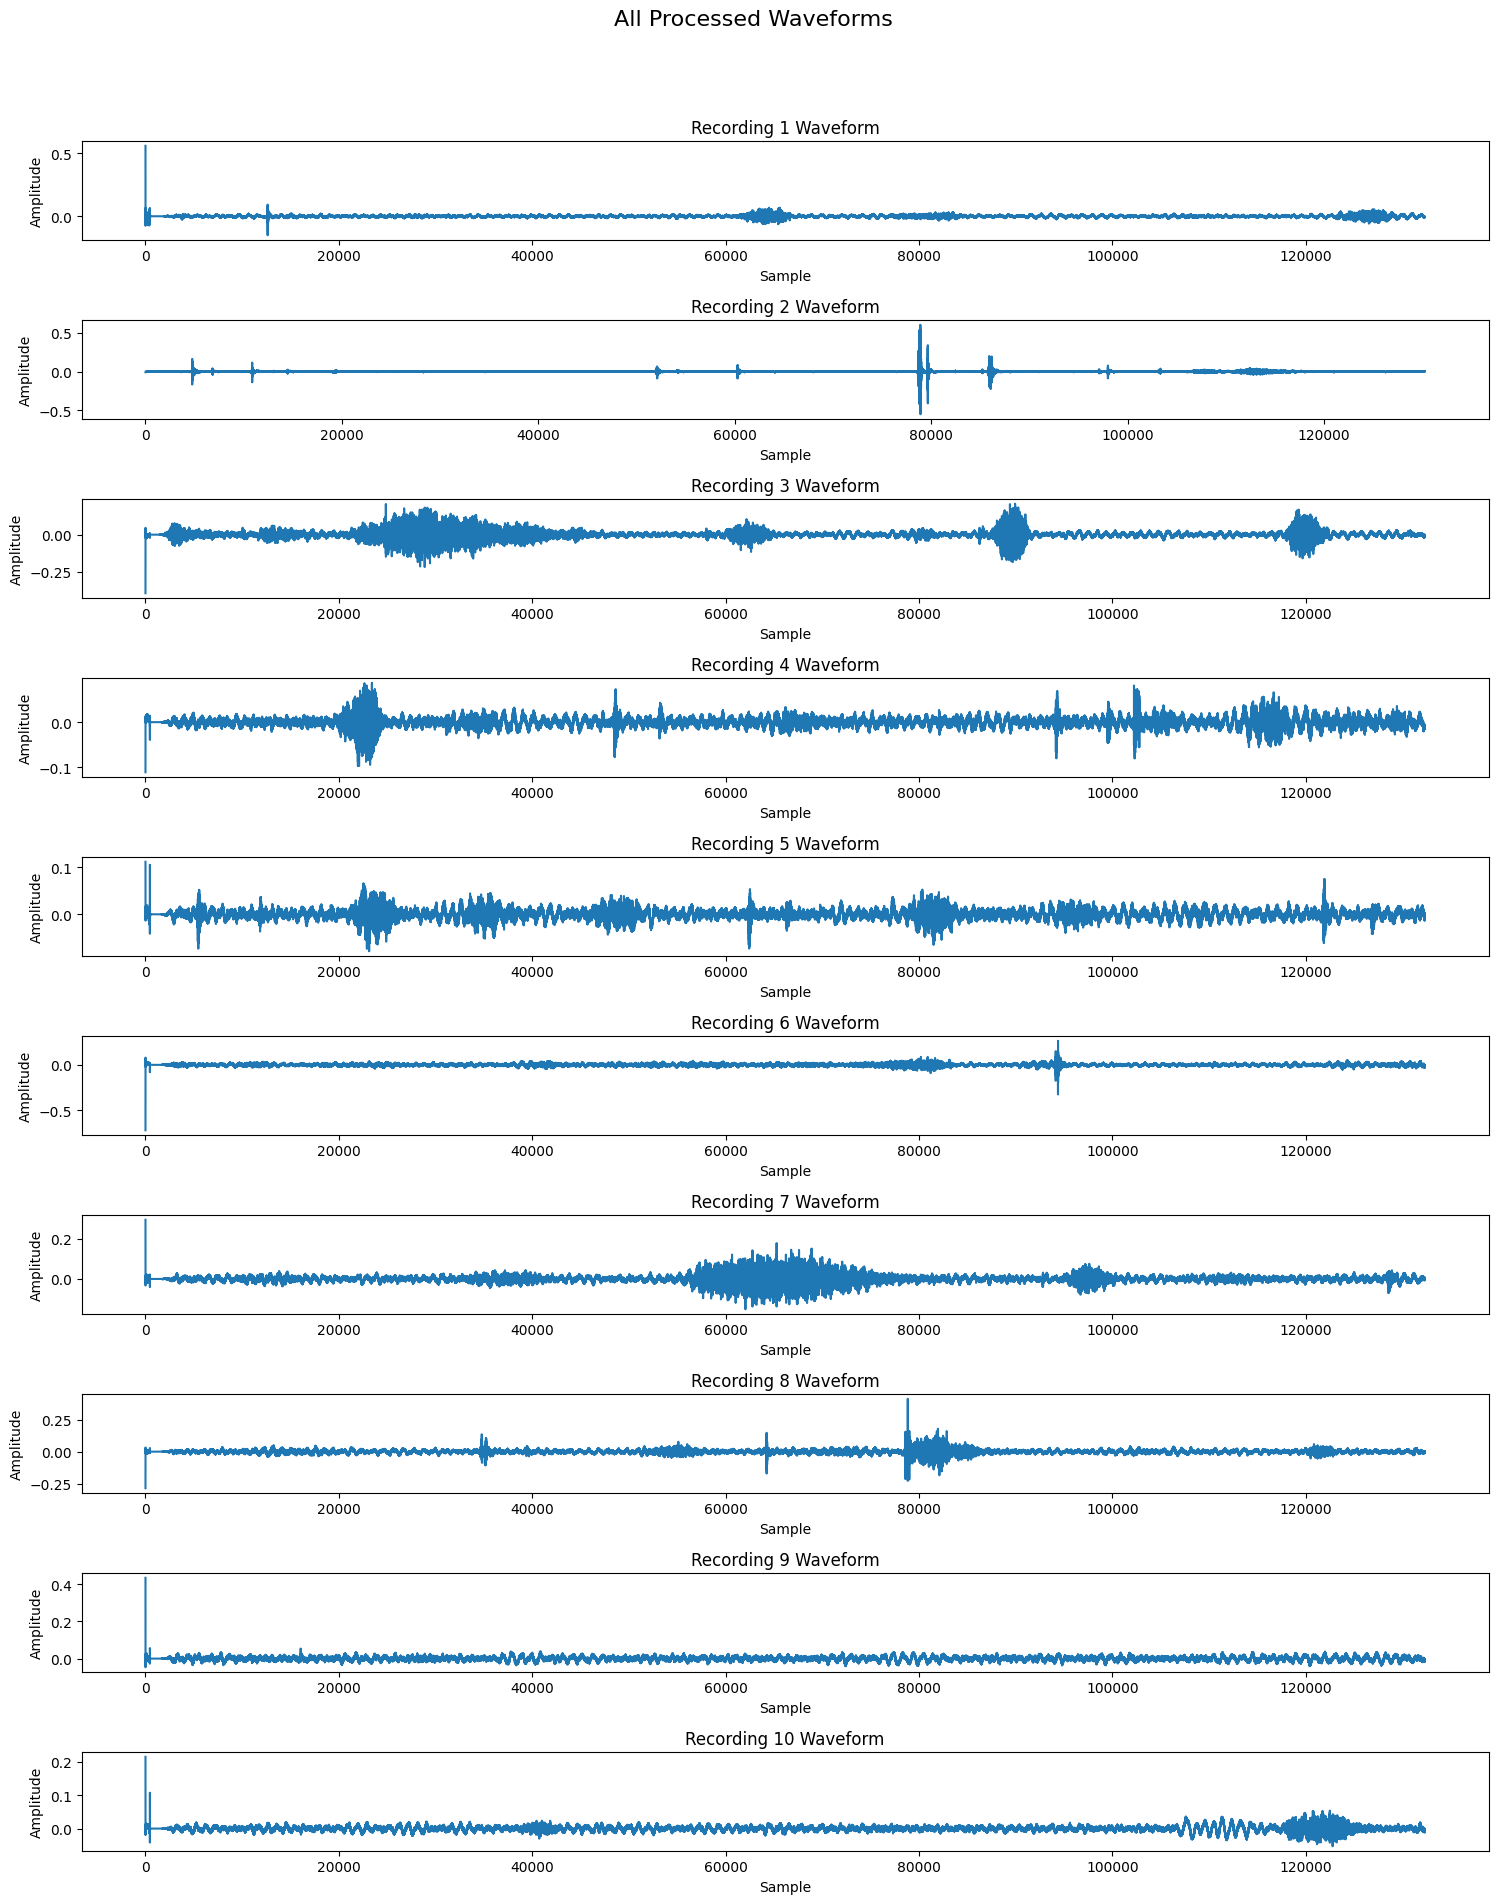

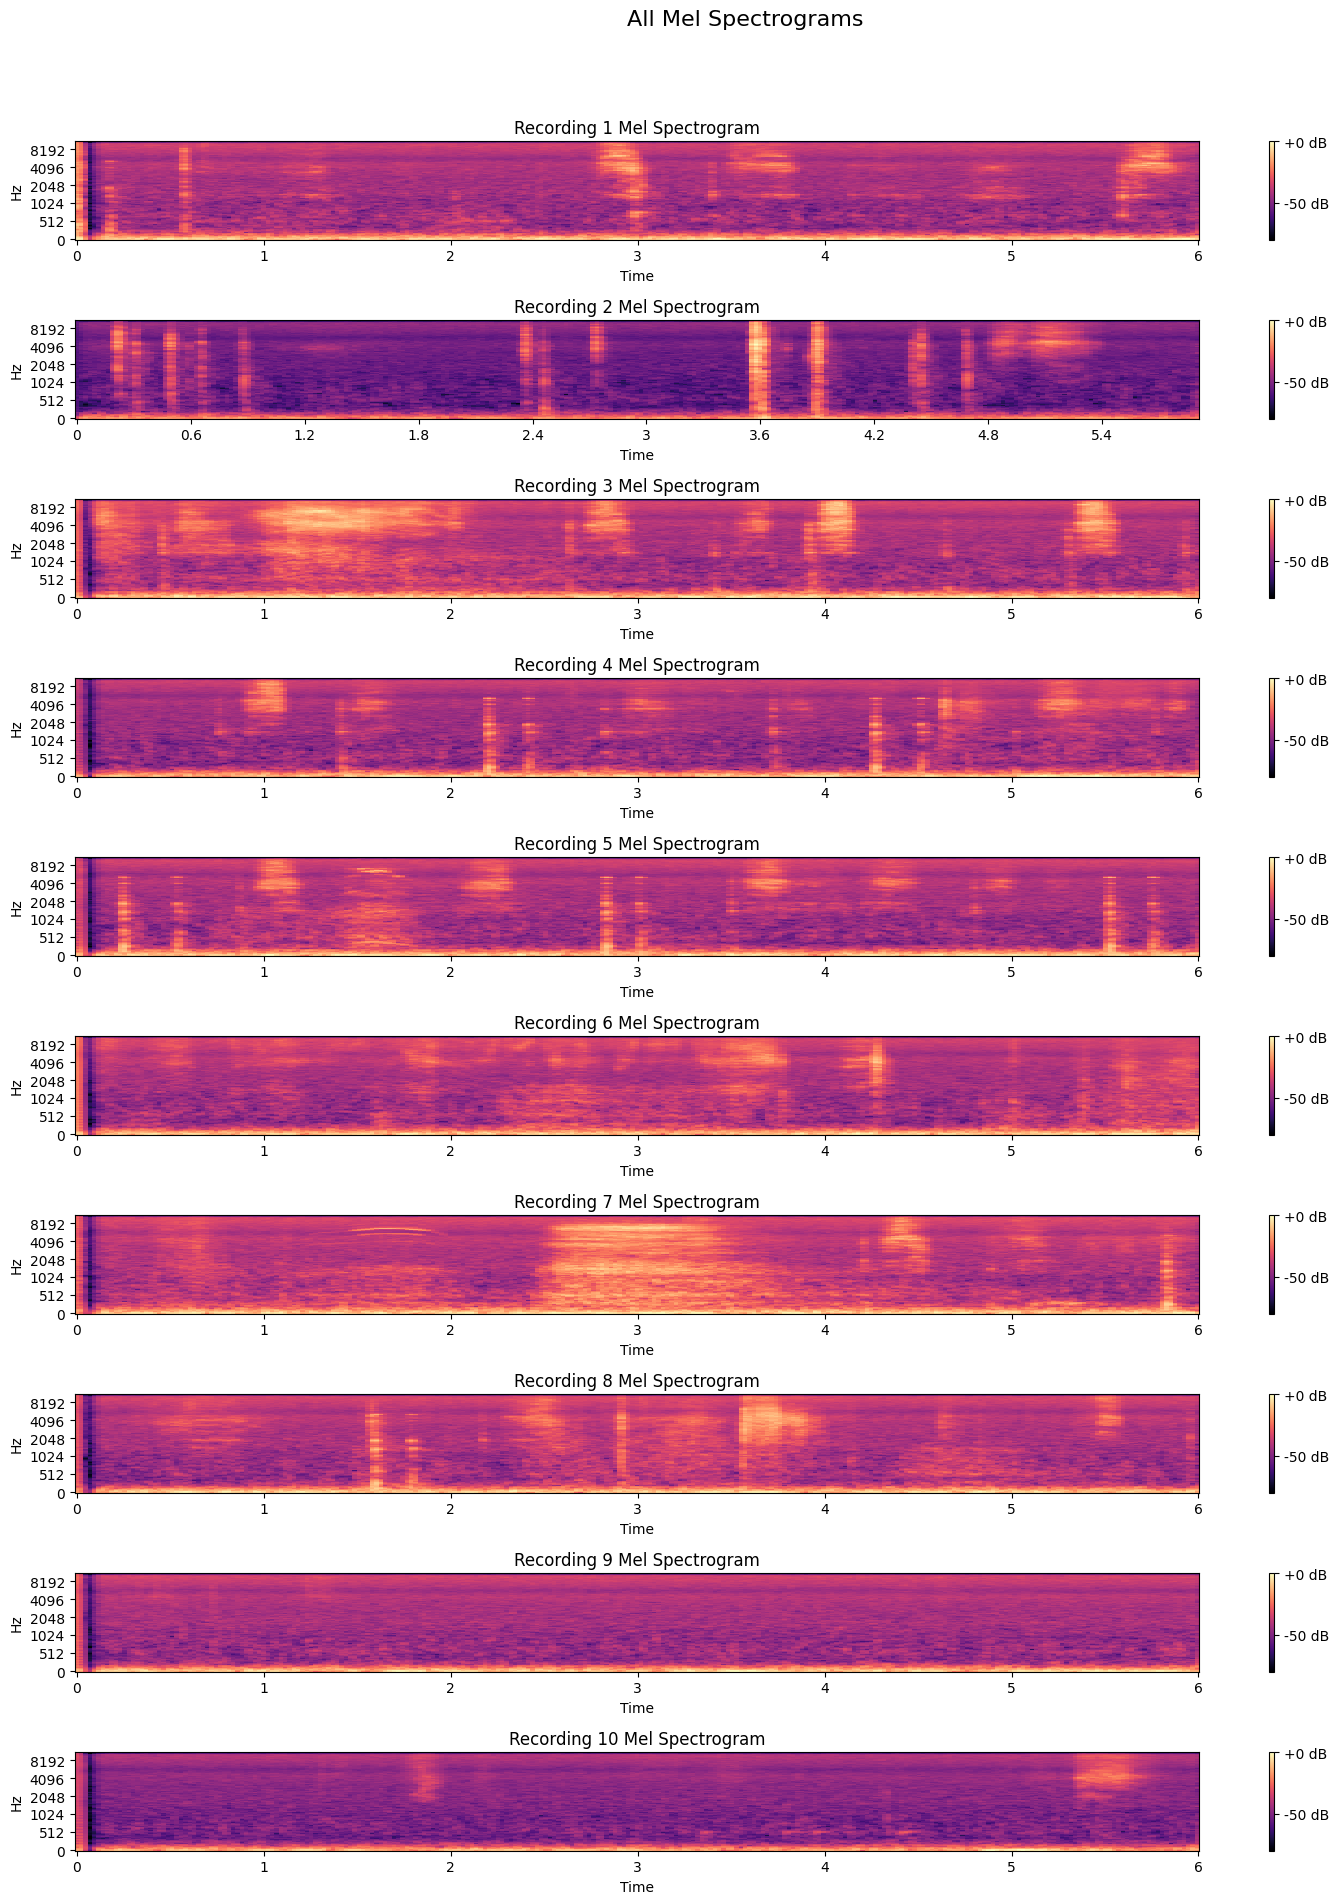

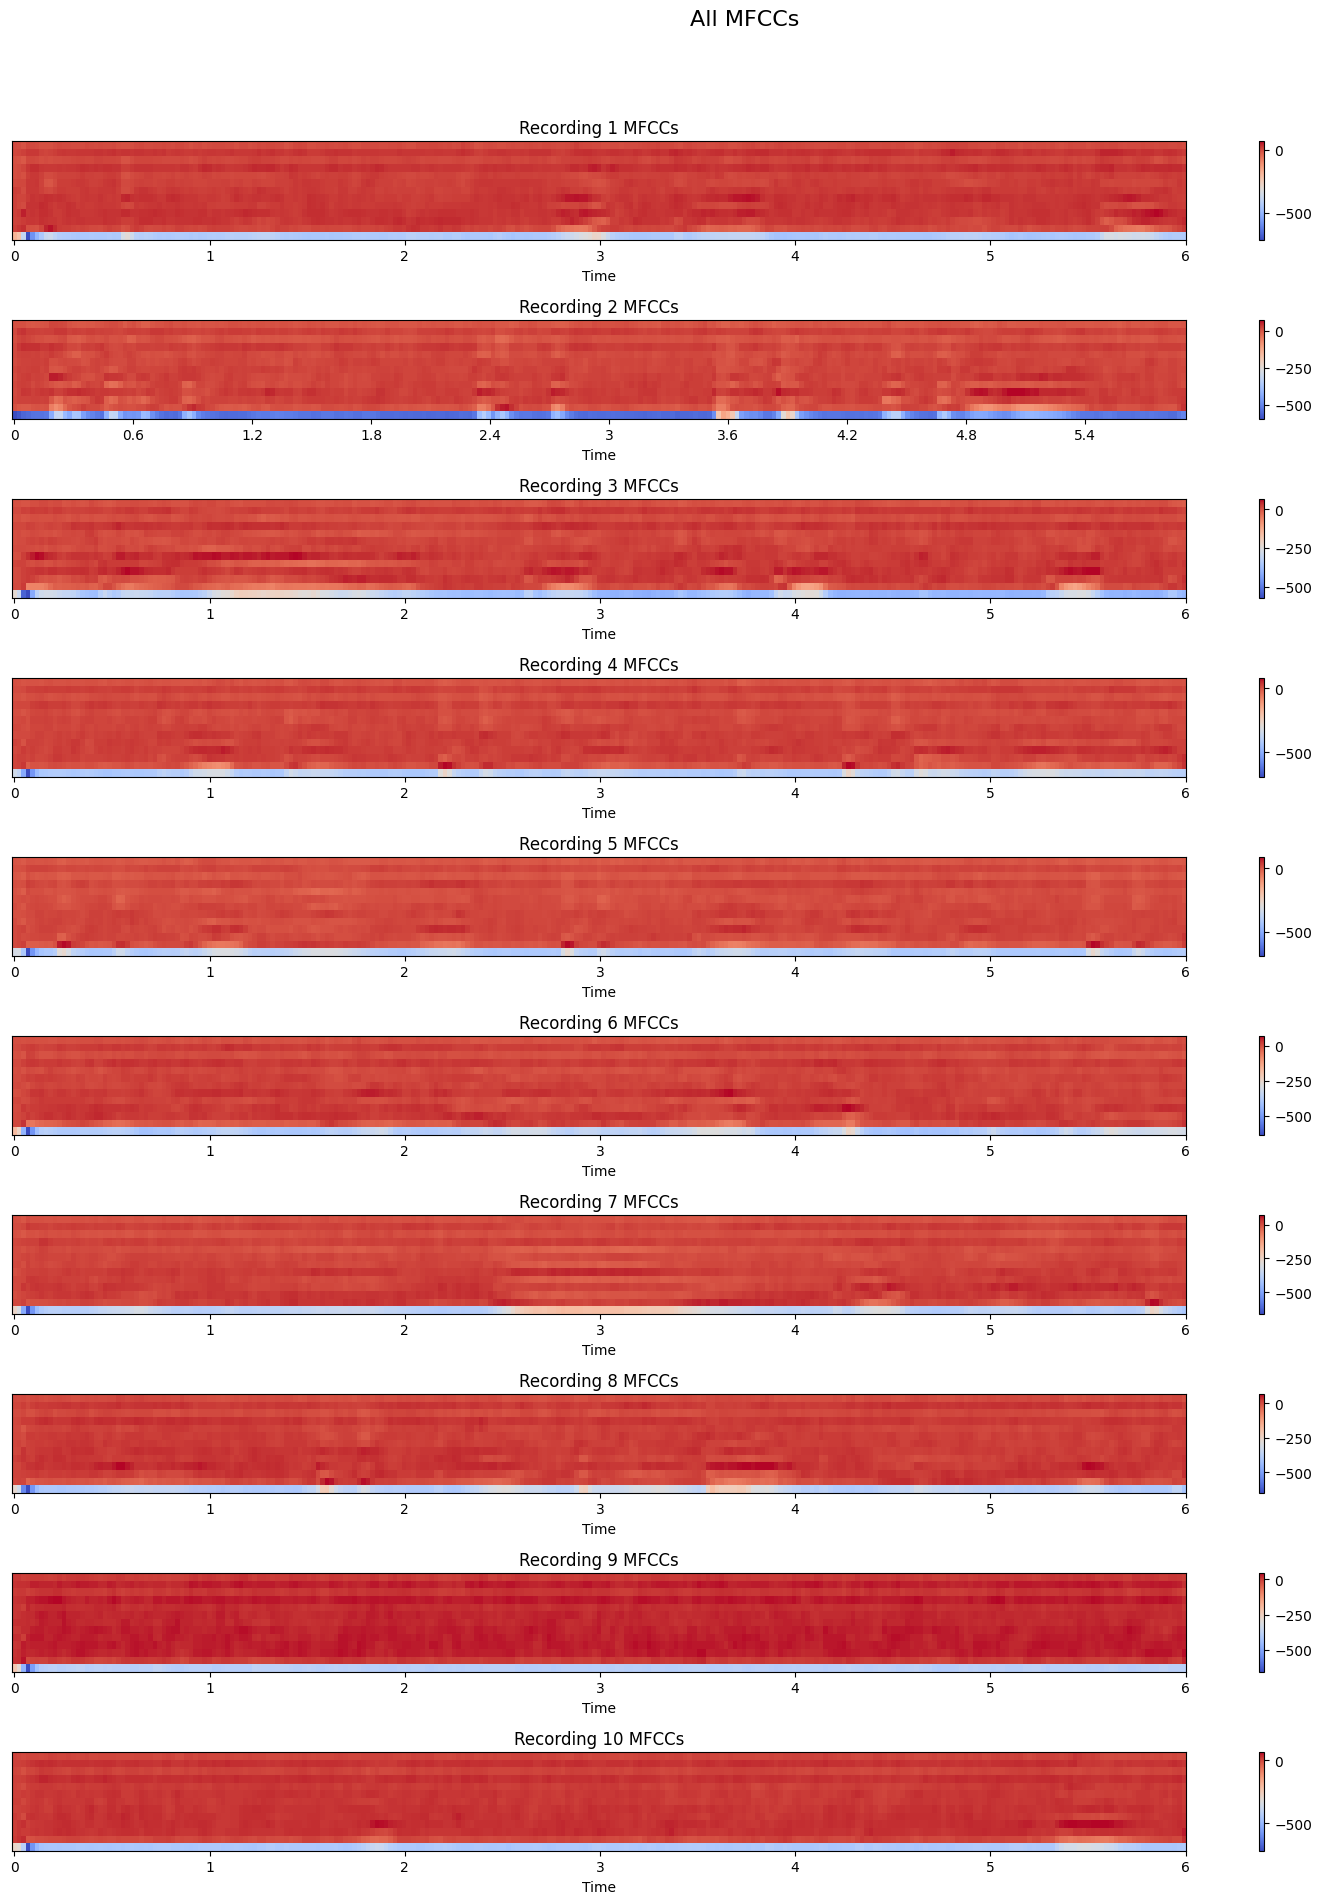


Batch Processing Report:
   Recording ID                  Timestamp  Raw Duration  Processed Duration  \
0             1 2024-10-26 11:13:02.307663           3.0             3.00000   
1             2 2024-10-26 11:13:07.563152           3.0             2.95356   
2             3 2024-10-26 11:13:12.821226           3.0             3.00000   
3             4 2024-10-26 11:13:18.069270           3.0             3.00000   
4             5 2024-10-26 11:13:23.318661           3.0             3.00000   
5             6 2024-10-26 11:13:28.571467           3.0             3.00000   
6             7 2024-10-26 11:13:33.826897           3.0             3.00000   
7             8 2024-10-26 11:13:39.081917           3.0             3.00000   
8             9 2024-10-26 11:13:44.338597           3.0             3.00000   
9            10 2024-10-26 11:13:49.592897           3.0             3.00000   

  MFCC Shape Mel Spec Shape  
0  (13, 259)     (128, 259)  
1  (13, 255)     (128, 255)  
2  

In [3]:
# Run the batch processing
processor = run_batch_processing()

In [7]:
import seaborn as sns  # This was missing
from sklearn.decomposition import PCA 

Running complete analysis of preprocessed audio...
Analyzing preprocessed audio samples...


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (10, 128) + inhomogeneous part.

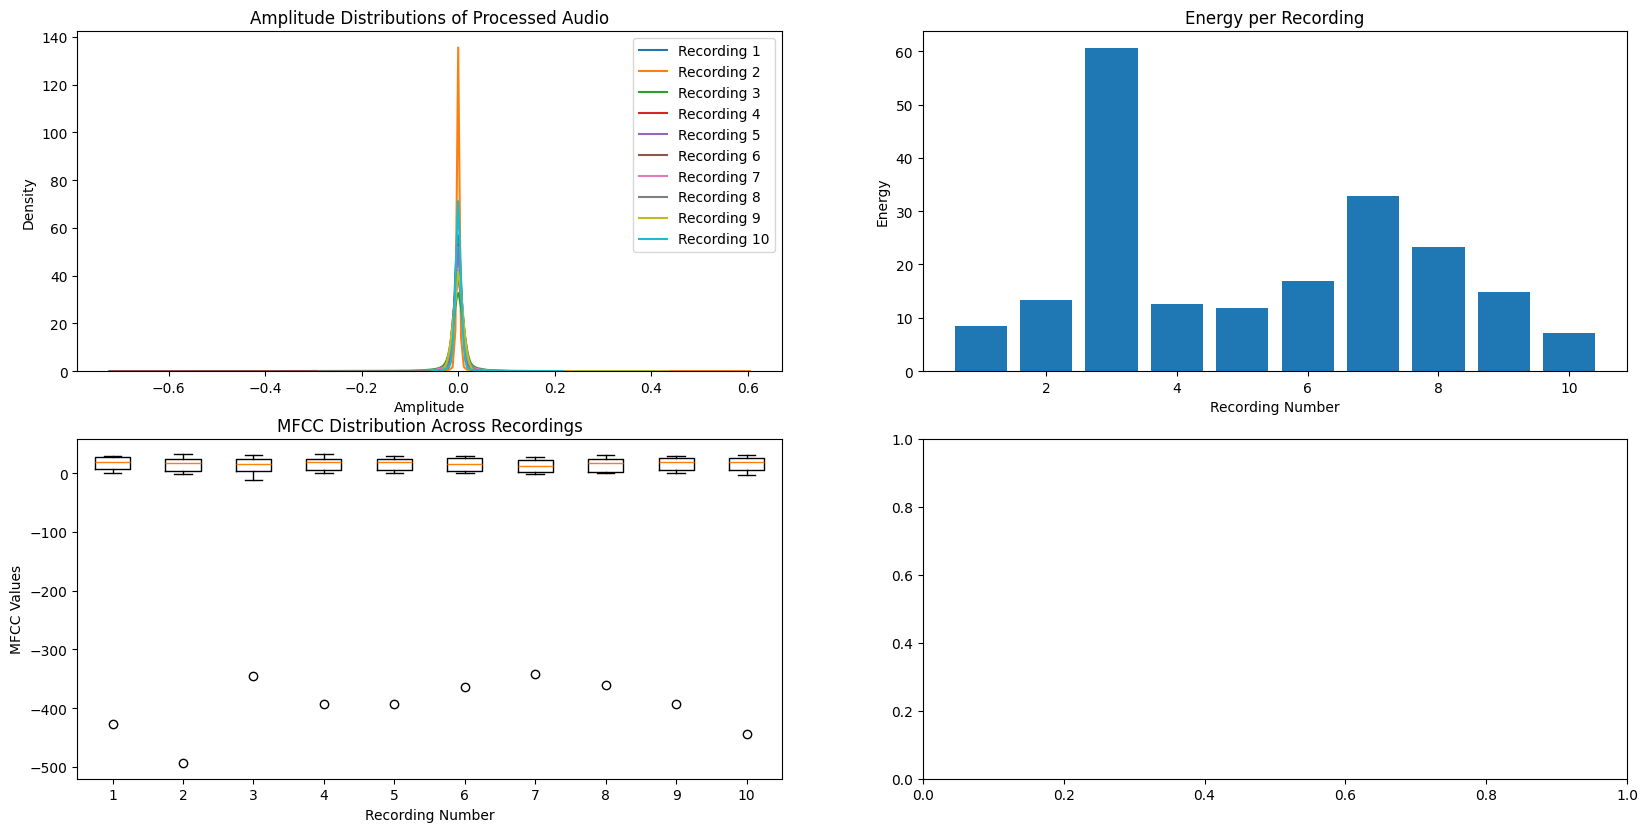

In [8]:
class AudioAnalyzer:
    def __init__(self, processor):
        self.processor = processor
        self.features = processor.features
        
    def analyze_preprocessed_audio(self):
        """Analyze the preprocessed audio samples"""
        print("Analyzing preprocessed audio samples...")
        
        # Create figure with multiple subplots
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Amplitude Distribution Comparison
            # Shows how loud/quiet parts are distributed in each recording
            # Each line represents one recording
            # Higher peaks mean those amplitude values occur more frequently
            # Helps you see if recordings have consistent volume levels
        plt.subplot(3, 2, 1)
        for i, feat in enumerate(self.features):
            sns.kdeplot(feat['processed_audio'], label=f'Recording {i+1}')
        plt.title('Amplitude Distributions of Processed Audio')
        plt.xlabel('Amplitude')
        plt.ylabel('Density')
        plt.legend()
        
        # 2. Energy Comparison
            # Shows total energy (loudness) of each recording
            # Taller bars = louder recordings
            # Helps identify if some recordings are significantly louder/quieter than others
            # Good for checking recording consistency
        plt.subplot(3, 2, 2)
        energies = [np.sum(feat['processed_audio']**2) for feat in self.features]
        plt.bar(range(1, len(energies) + 1), energies)
        plt.title('Energy per Recording')
        plt.xlabel('Recording Number')
        plt.ylabel('Energy')
        
        # 3. MFCC Comparison
            # Shows voice characteristics distribution
            # Each box shows the range of voice features
            # Middle line = average value
            # Whiskers = range of values
            # Dots = outliers
            # Helps identify consistent voice patterns
        plt.subplot(3, 2, 3)
        mfcc_means = [np.mean(feat['mfccs'], axis=1) for feat in self.features]
        plt.boxplot(mfcc_means)
        plt.title('MFCC Distribution Across Recordings')
        plt.xlabel('Recording Number')
        plt.ylabel('MFCC Values')
        
        # 4. Mel Spectrogram Average
            # Shows average frequency content across all recordings
            # Brighter colors = stronger frequencies
            # X-axis = time
            # Y-axis = frequency
            # Good for seeing which frequencies are consistently present
        plt.subplot(3, 2, 4)
        avg_mel_spec = np.mean([feat['mel_spec'] for feat in self.features], axis=0)
        librosa.display.specshow(librosa.power_to_db(avg_mel_spec, ref=np.max),
                               y_axis='mel', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Average Mel Spectrogram Across All Recordings')
        
        # 5. Recording Similarity Matrix
            # Shows how similar each recording is to others
            # Darker red = more similar
            # Darker blue = less similar
            # Diagonal is always 1 (recording compared to itself)
            # Helps identify which recordings are most alike
        plt.subplot(3, 2, 5)
        n_recordings = len(self.features)
        similarity_matrix = np.zeros((n_recordings, n_recordings))
        for i in range(n_recordings):
            for j in range(n_recordings):
                similarity_matrix[i,j] = np.corrcoef(
                    self.features[i]['processed_audio'],
                    self.features[j]['processed_audio']
                )[0,1]
        sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
        plt.title('Recording Similarity Matrix')
        
        # 6. Feature Statistics
            # Calculates numerical summaries of each recording
            # Shows basic statistics like average, variation, max/min
            # Helps identify outliers or unusual recordings
        stats_data = []
        for i, feat in enumerate(self.features):
            audio = feat['processed_audio']
            stats_data.append({
                'Recording': i+1,
                'Mean': np.mean(audio),
                'Std': np.std(audio),
                'Max': np.max(audio),
                'Min': np.min(audio),
                'Duration': len(audio) / self.processor.fs
            })
        
        stats_df = pd.DataFrame(stats_data)
        plt.subplot(3, 2, 6)
        stats_df[['Mean', 'Std', 'Max', 'Min']].boxplot()
        plt.title('Statistical Distribution of Audio Features')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistical summary
        print("\nStatistical Summary of Recordings:")
        print(stats_df.describe())
        
        return stats_df

    # MFCC Pattern Analysis (PCA)
        # Reduces complex voice features to 2D plot
        # Each point represents one recording
        # Similar recordings appear closer together
        # Helps visualize groupings or outliers
    def analyze_mfcc_patterns(self):
        """Analyze patterns in MFCC features"""
        # PCA on MFCCs
        mfcc_features = np.array([np.mean(feat['mfccs'], axis=1) for feat in self.features])
        pca = PCA(n_components=2)
        mfcc_2d = pca.fit_transform(mfcc_features)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(mfcc_2d[:, 0], mfcc_2d[:, 1])
        for i, (x, y) in enumerate(mfcc_2d):
            plt.annotate(f'Recording {i+1}', (x, y))
        plt.title('PCA of MFCC Features')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.show()
        
        # Explained variance
        print("\nExplained variance ratio:", pca.explained_variance_ratio_)
    
    def run_analysis(self):
        """Run complete analysis"""
        print("Running complete analysis of preprocessed audio...")
        stats_df = self.analyze_preprocessed_audio()
        self.analyze_mfcc_patterns()
        return stats_df

# Use the analyzer
analyzer = AudioAnalyzer(processor)
stats_df = analyzer.run_analysis()